# CS 524 - Homework 4

## Question 1a (i)
Decision variables:
- the start time $t_i$ for each task

Constraints:
- each task has to wait for its prerequisite to complete before it can start (if it has any) expressed below:
$$ t_i \ge t_j + d_j \quad \forall i \in T \quad \forall j \in P$$
where T is all the tasks and P is the prerequisites for that task $t_i$
- due to how this constraint is set up, the first task will have a start time of 0:
$$ t_1 = 0 $$

Objective: minimize the total build time, essentially minimizing the build time for the last task
$$ min \quad t_{18} + d_{18} $$ where $t_{18}$ and $d_{18}$ are the start time and duration for the last task

## Question 1a (ii)

In [1]:
using JuMP, Clp, NamedArrays

# data for building stadium
tasks = 1:18
durations = [2 16 9 8 10 6 2 2 9 5 3 2 1 7 4 3 9 1]
predecessors = ( [], [1], [2], [2], [3], [4,5], [4], [6], [4,6], [4], [6], [9], [7], [2], [4,14], [8,11,14], [12], [17] )
pred_dict = Dict(zip(tasks,predecessors));   # dictionary mapping tasks --> predecessors.

m_stadium = Model(with_optimizer(Clp.Optimizer))
@variable(m_stadium, start[tasks])
@constraint(m_stadium, start[1] == 0) # init first task start time

for t in tasks # for each task
    for p in predecessors[t] # for each prereq of t
        @constraint(m_stadium, start[t] >= start[p] + durations[p])
    end
end

@objective(m_stadium, Min, start[18] + durations[18])

optimize!(m_stadium)
println("The stadium will take ", objective_value(m_stadium), " weeks to build.")
println()

The stadium will take 64.0 weeks to build.

Coin0506I Presolve 0 (-23) rows, 0 (-18) columns and 0 (-45) elements
Clp3002W Empty problem - 0 rows, 0 columns and 0 elements
Clp0000I Optimal - objective value 64
Coin0511I After Postsolve, objective 64, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 64 - 0 iterations time 0.002, Presolve 0.00


## Question 1b (i)
Decision variables:
- the start time for each task $t_i$
- the amount of weeks for task after reduction $amt_i$

Constraints:
- each task has to wait for its prerequisite to complete before it can start where T is all the tasks and P is the prerequisites for that task $t_i$
$$ t_i \ge t_j + d_j \quad \forall i \in T \quad \forall j \in P$$
- due to how this constraint is set up, the first task will have a start time of 0:
$$ t_1 = 0 $$
- the new duration (after reduction) must not exceed the original duration but can't be lower than it's max reduciton:
$$ durations_i - max\text{_}reduction_i \le amt_i \le durations_i $$

Objective: maximize the profit based on how many weeks were reduced (from the original 64 weeks)
$$ max \quad 30 * (64 - start_{18} - amt_{18}) - cost_T $$
<br/>where $amt_{18}$ is the new, reduced duration and $cost_T$ is the sum of $cost_i = amt_i * cost\text{_}reduction[i]$ for all tasks

## Question 1b (ii)

In [2]:
max_reduction =  [0,  3,  1,  2,  2,  1, 1, 0,  2,  1,  1, 0, 0,  2,  2, 1,  3, 0]  # max reduction (in weeks)
cost_reduction = [0, 30, 26, 12, 17, 15, 8, 0, 42, 21, 18, 0, 0, 22, 12, 6, 16, 0]  # cost of reduction ($1,000/week)
bonus_amount = 30     # bonus for expediting the project ($1,000/week )

m_stadium_bonus = Model(with_optimizer(Clp.Optimizer))

@variable(m_stadium_bonus, start[tasks])
@variable(m_stadium_bonus, amt[tasks])

@constraint(m_stadium_bonus, start[1] == 0)

for t in tasks
    for p in predecessors[t]
        @constraint(m_stadium_bonus, start[t] >= start[p] + amt[p])
    end
end

for t in tasks
    @constraint(m_stadium_bonus, durations[t] - max_reduction[t] <= amt[t] <= durations[t])
end


@objective(m_stadium_bonus, Max, 
    bonus_amount*(64-start[18]-amt[18]) - sum((durations[i]-amt[i]) * cost_reduction[i] for i in tasks))

optimize!(m_stadium_bonus)
println("The stadium w/ bonus will take ", value.(start[18]+amt[18]), " weeks to build.")
println("The profit will be \$", objective_value(m_stadium_bonus), "k")
println()

The stadium w/ bonus will take 57.0 weeks to build.
The profit will be $87.0k

Coin0506I Presolve 3 (-38) rows, 8 (-28) columns and 18 (-67) elements
Clp0006I 0  Obj 42.000014 Primal inf 0.09999947 (1) Dual inf 157.99999 (7)
Clp0006I 1  Obj 87
Clp0000I Optimal - objective value 87
Coin0511I After Postsolve, objective 87, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 87 - 1 iterations time 0.002, Presolve 0.00


## Question 2

In [9]:
position = [0 0; 20 20; 18 10; 30 12; 35 0; 33 25; 5 27; 5 10; 11 0; 2 15]
present = [8; 13; 4; 8; 12; 2; 14; 11; 15; 7]
required = [10; 6; 8; 11; 9; 7; 15; 7; 9; 12]

to = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
from = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

function cost(x1, y1, x2, y2)
    a = (x2 - x1)^2 + (y2 - y1)^2
    return 1.3 * sqrt(a)
end

m_car = Model(with_optimizer(Clp.Optimizer))

# the cars to an agency to another agency
@variable(m_car, car[to, from] >= 0)

# the receiving agency meets its demand = required - present
@constraint(m_car, a[i in to], sum(car[i,j] for j in from if i != j) == (required[i] < present[i] ? 0 : required[i]-present[i]))

# the agencies that can give, give their most
@constraint(m_car, b[j in from], sum(car[i,j] for i in to if i != j) == (required[j] > present[j] ? 0 : present[j]-required[j]))

# minimize the cost
@objective(m_car, Min, 0.5 * sum( car[i,j] * cost(position[i,1],position[i,2],position[j,1],position[i,2]) for i in to, j in from ))

optimize!(m_car)
assignment = NamedArray( [ (value.(car[i,j])) for i in to, j in from ], (to, from), ("to","from"))
println(assignment, "\n")
println("The cost to move the cars (optimally) is \$", objective_value(m_car), "\n")

10×10 Named Matrix{Float64}
to ╲ from │   1    2    3    4    5    6    7    8    9   10
──────────┼─────────────────────────────────────────────────
1         │ 0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0
2         │ 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3         │ 0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0
4         │ 0.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5         │ 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
6         │ 0.0  2.0  0.0  0.0  3.0  0.0  0.0  0.0  0.0  0.0
7         │ 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
8         │ 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
9         │ 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
10        │ 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  4.0  0.0

The cost to move the cars (optimally) is $83.85000000000001

Coin0506I Presolve 10 (-10) rows, 24 (-76) columns and 48 (-132) elements
Clp0006I 0  Obj 0 Primal inf 39.99999 (10)
Clp0006I 12  Obj 83.85
Clp0000I Optimal - objective value 83.

## Question 3a
PRIMAL
$$max \quad 5S + 8L $$
$$\text{subject to} \quad 3S + 2L \le 160$$
$$\quad\quad\quad S + 4L \le 200$$
$$\quad\quad\quad S, L \ge 0$$

optimal solution lies at (44,24) and $p* = 5(24) + 8(44) = 472$

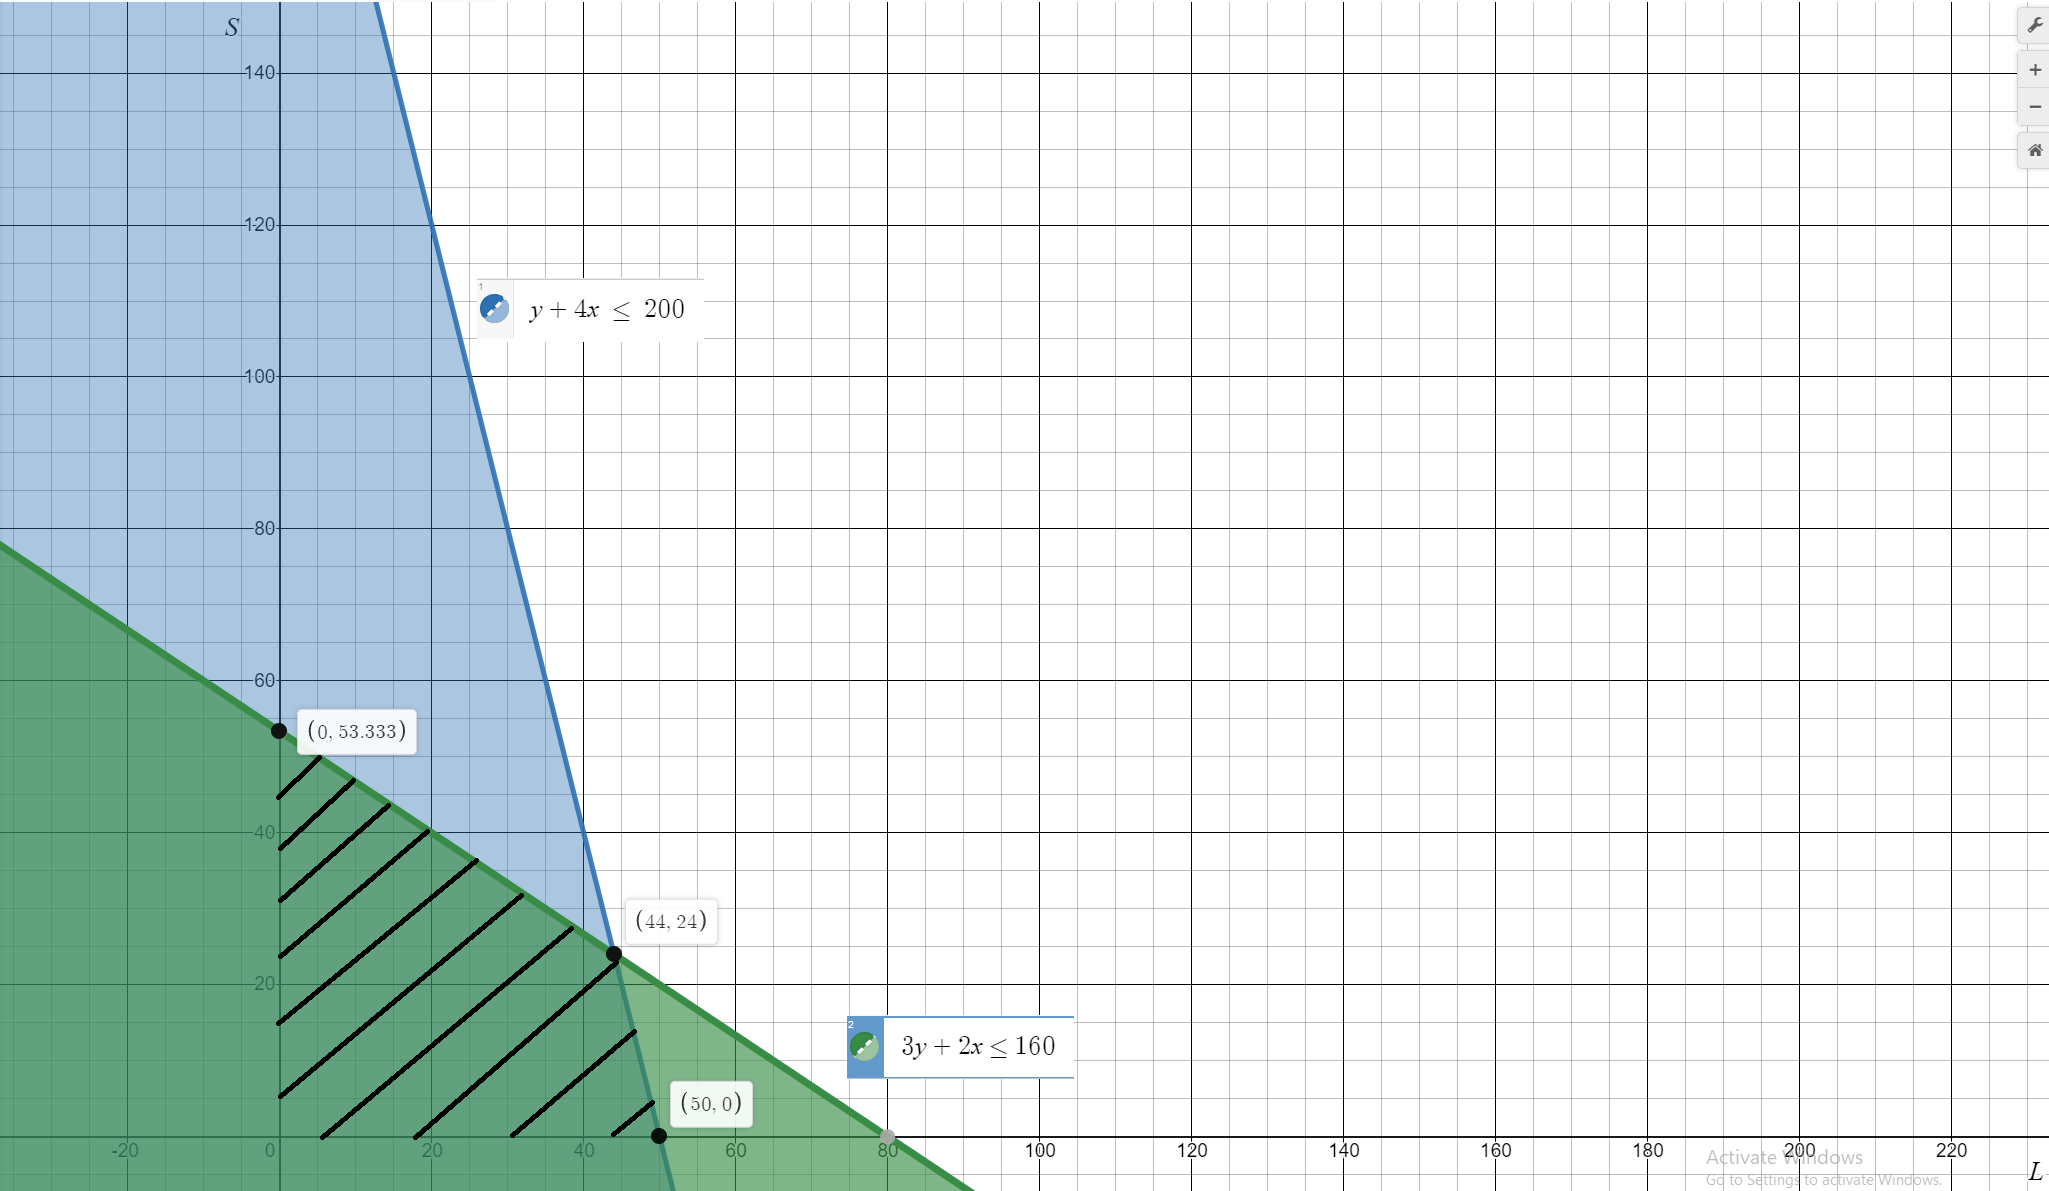

## Question 3b
DUAL
$$min \quad 160\lambda_1 +200\lambda_2 $$
$$\text{subject to} \quad 3\lambda_1 + \lambda_2 + \lambda_3 \ge 5$$
$$\quad\quad\quad 2\lambda_1 + 4\lambda_2 + \lambda_4 \ge 8$$
$$\quad\quad\quad \lambda_1, \lambda_2, \lambda_3, \lambda_4 \ge 0$$

optimal solution lies at (1.4, 1.2) and $d* = 160(1.2) + 200(1.4) = 472$ <br/>
therefore, $p* == d*$

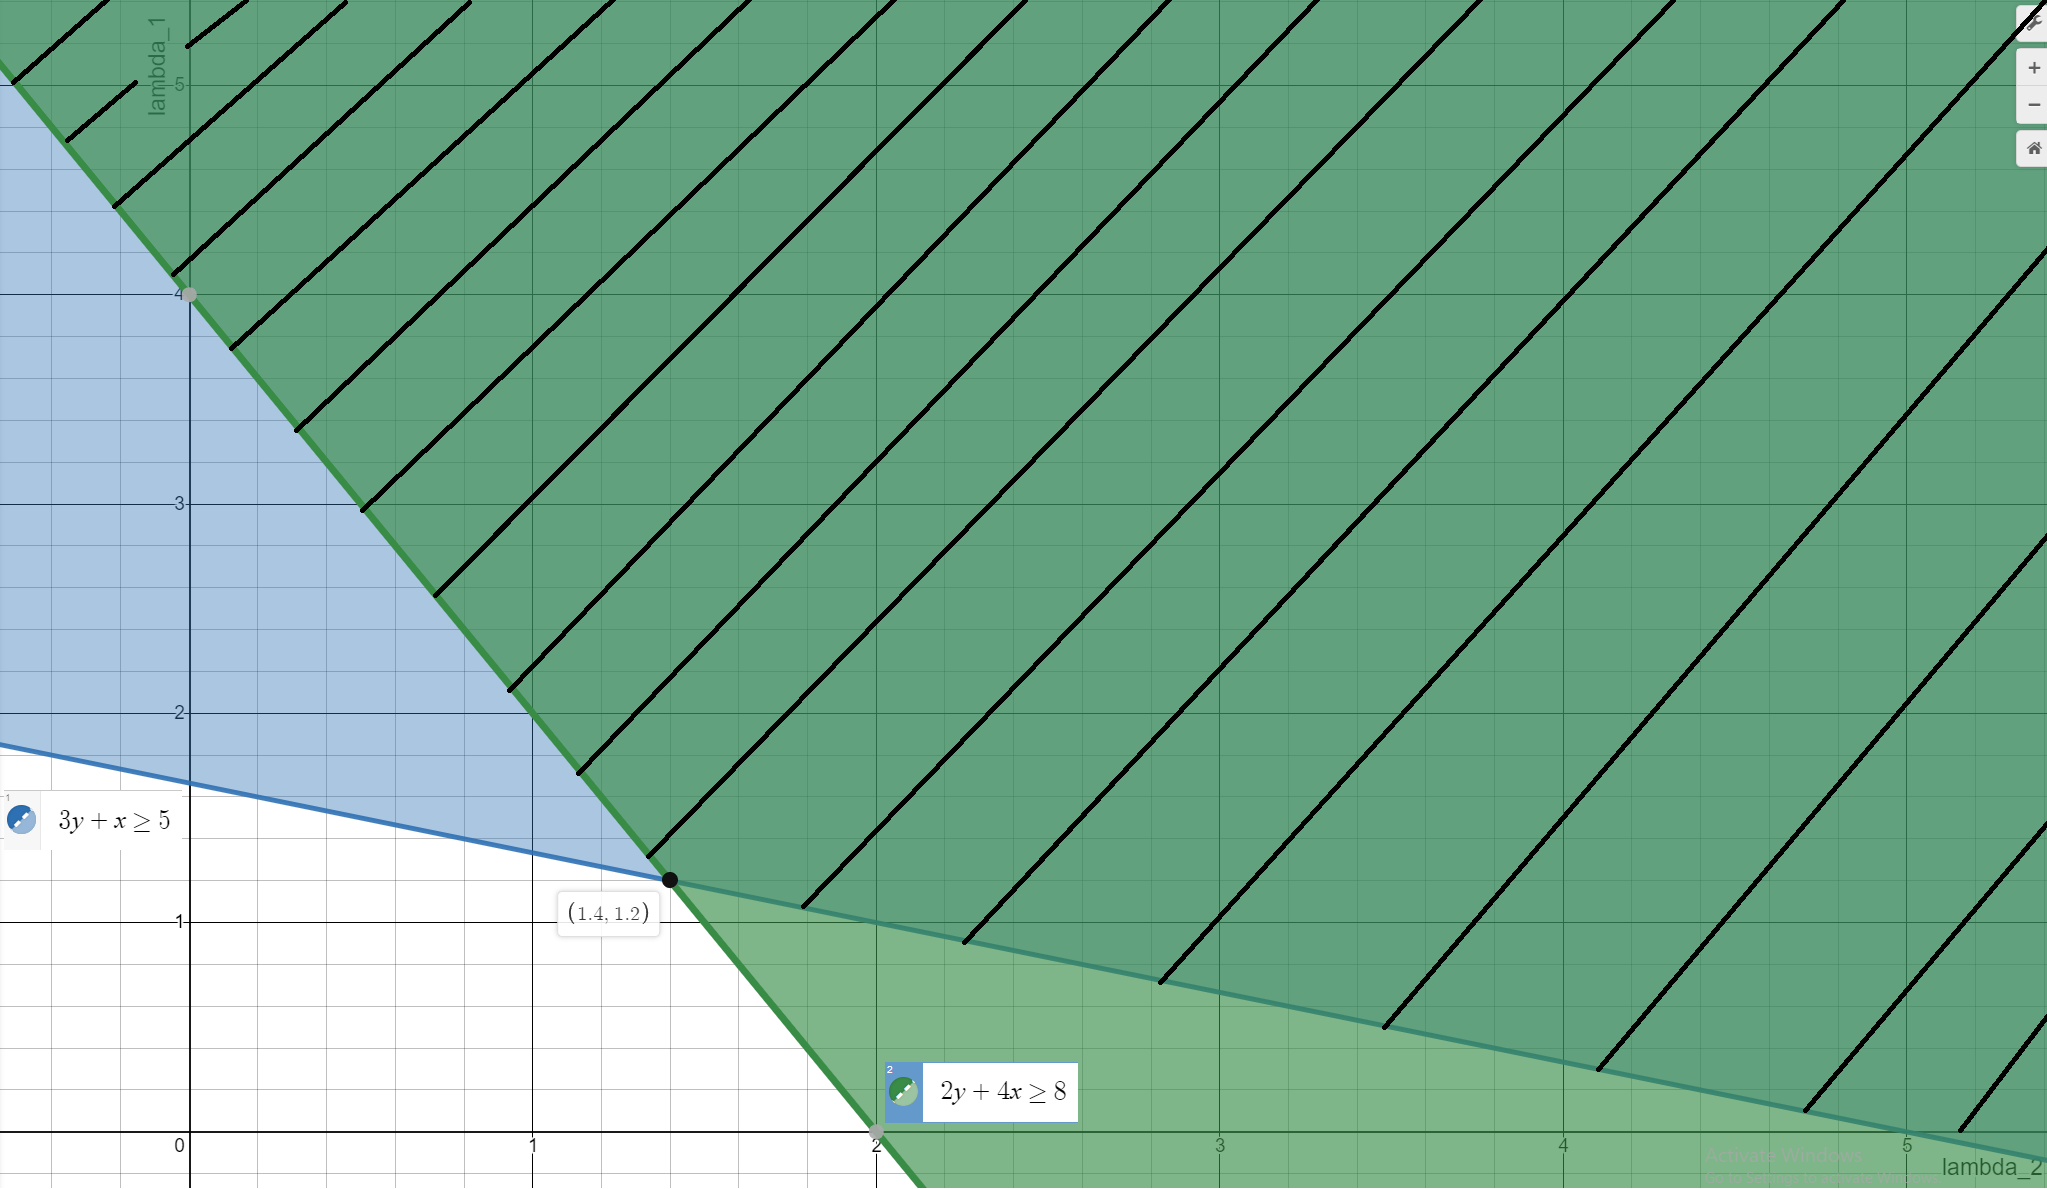